In [1]:
setwd('../../')
source('.Rprofile')
setwd('./evaluation/analysis')

library(ggplot2)
library(tidyverse)
library(plyr)
library(dplyr)
library(ggpubr)
library(reshape2)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact



Attaching package: ‘ggpubr’


The following 

# Hyperparameters of SLAT

In [2]:
df <- read.csv("../results/hyperparam.csv") 
df <- df %>% mutate(feature_type = replace(feature_type, feature_type == 'dpca', 'Cross dataset SVD'))
df %>% tail(3)

,dataset,datasize,k_neighbors,feature_type,epochs,LGCN_layer,mlp_hidden,hidden_size,alpha,anchor_scale,⋯,lr_recon,batch_d_per_iter,batch_r_per_iter,smooth,seed,celltype_score,euclidean_dis,global_score,region_score,run_time
,<chr>,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
358,stereo_mouse_embryo,8000,5,Cross dataset SVD,6,1,256,2048,0.01,0.8,⋯,0.01,7,10,20,5,0.726375,0.03879968,0.70675,0.948000,14.34253
359,stereo_mouse_embryo,8000,5,Cross dataset SVD,6,1,256,2048,0.01,0.8,⋯,0.01,7,10,20,6,0.719125,0.03852511,0.69900,0.949875,14.49861
360,stereo_mouse_embryo,8000,5,Cross dataset SVD,6,1,256,2048,0.01,0.8,⋯,0.01,7,10,20,7,0.720875,0.03714304,0.70175,0.950750,14.03059


In [3]:
default_param <- c(k_neighbors =20, feature_type='Cross dataset SVD' ,epochs = 6, LGCN_layer = 1, mlp_hidden = 256, hidden_size = 2048, alpha = 0.01, anchor_scale = "0.8",
                   lr_mlp = 0.0001, lr_wd = 0.0001, lr_recon = 0.01, batch_d_per_iter = 7, batch_r_per_iter = 10, smooth=20)
scores <- c("global_score")

In [4]:
plot_param <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), color = "feature_type", palette = c("#3b4992","#3b4992","#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "CRI score") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0.65, 0.75)) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        plot <- plot + scale_x_continuous(trans='log2')
    } else if (str_detect(variable, 'epochs')) {
       plot <- plot + scale_x_continuous(breaks = c(2,4,6,8,10))
    }
    return(plot)
}

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


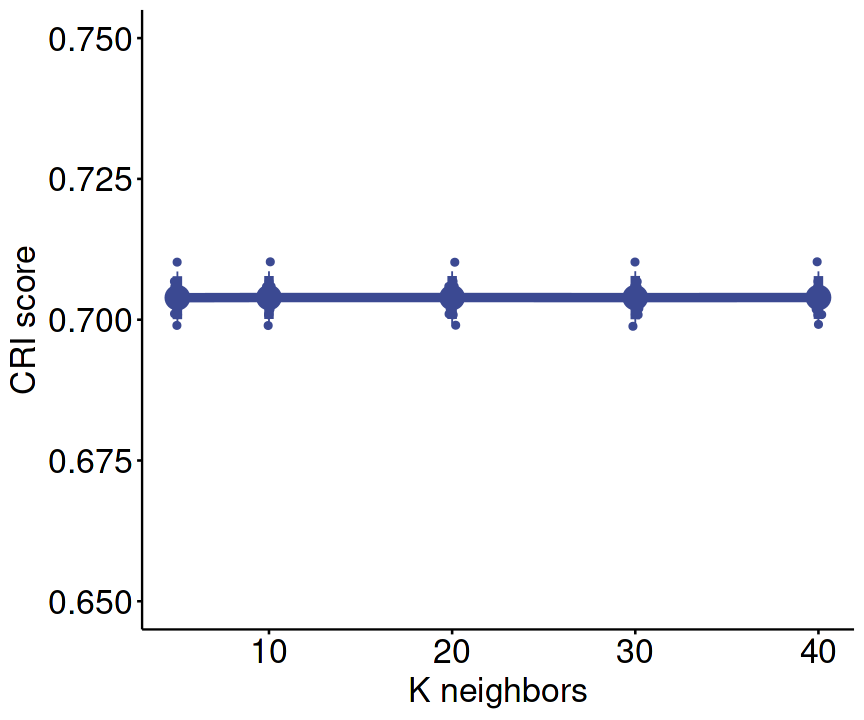

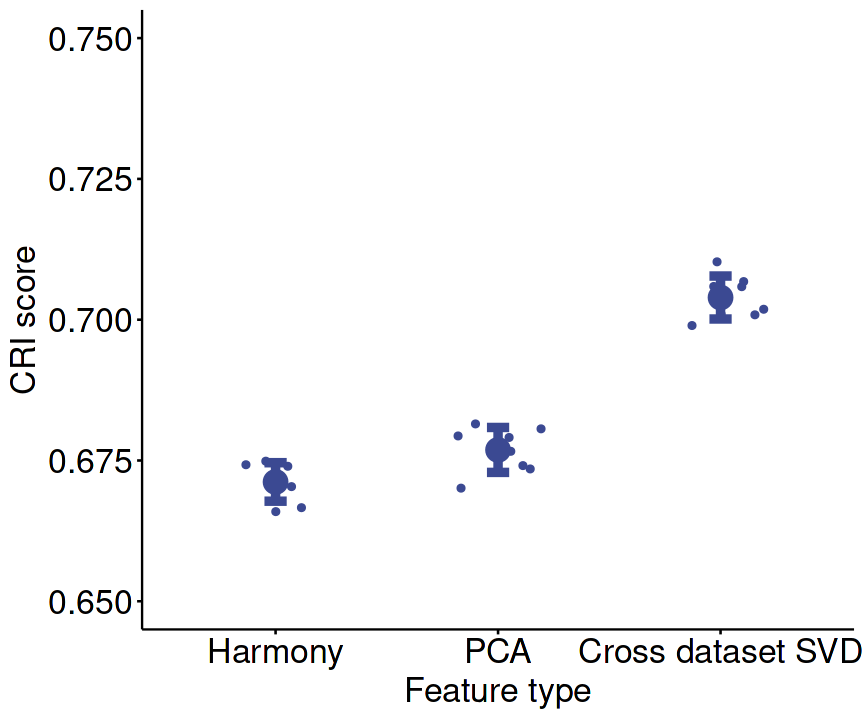

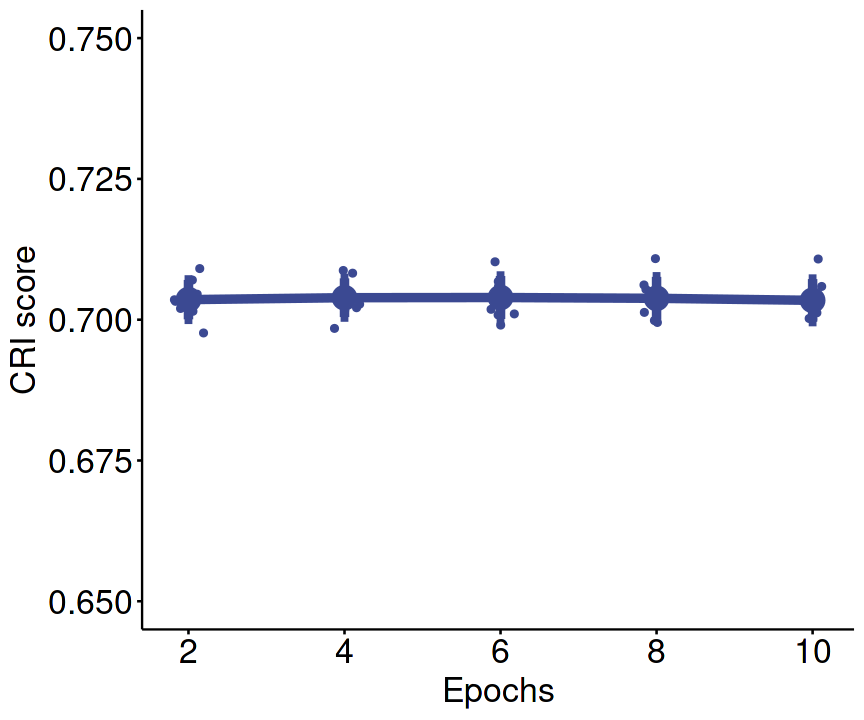

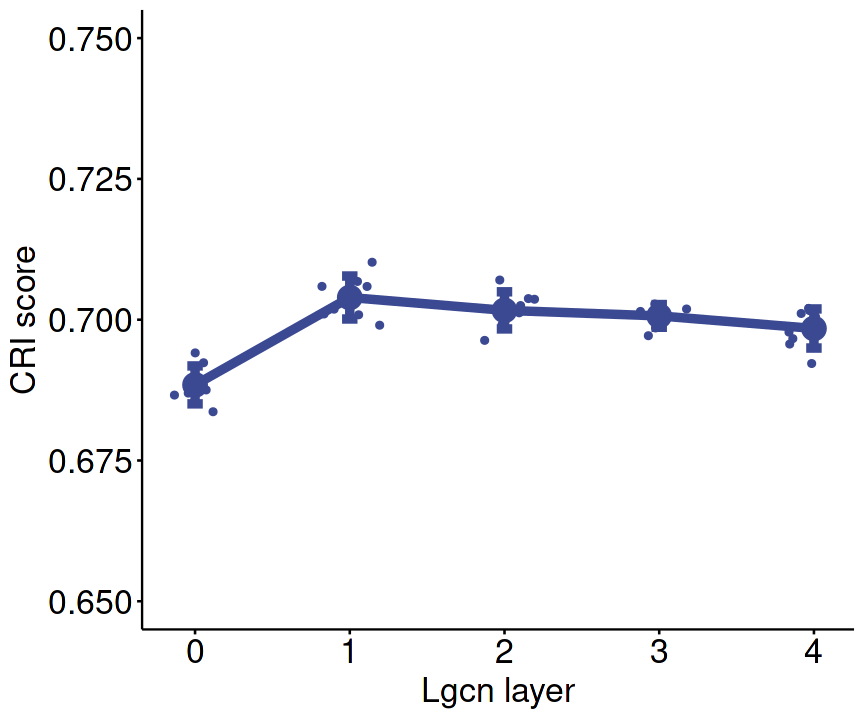

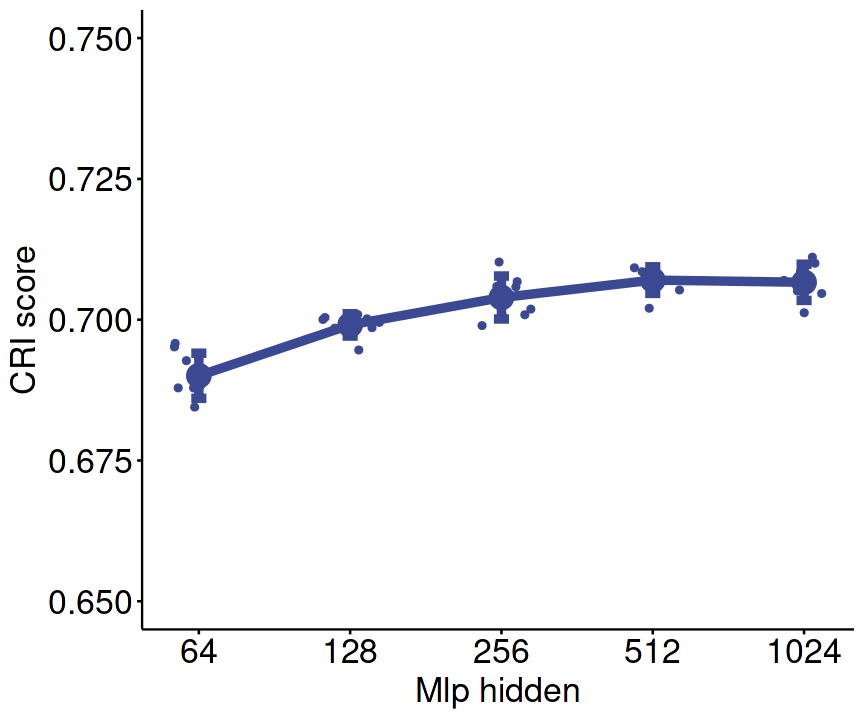

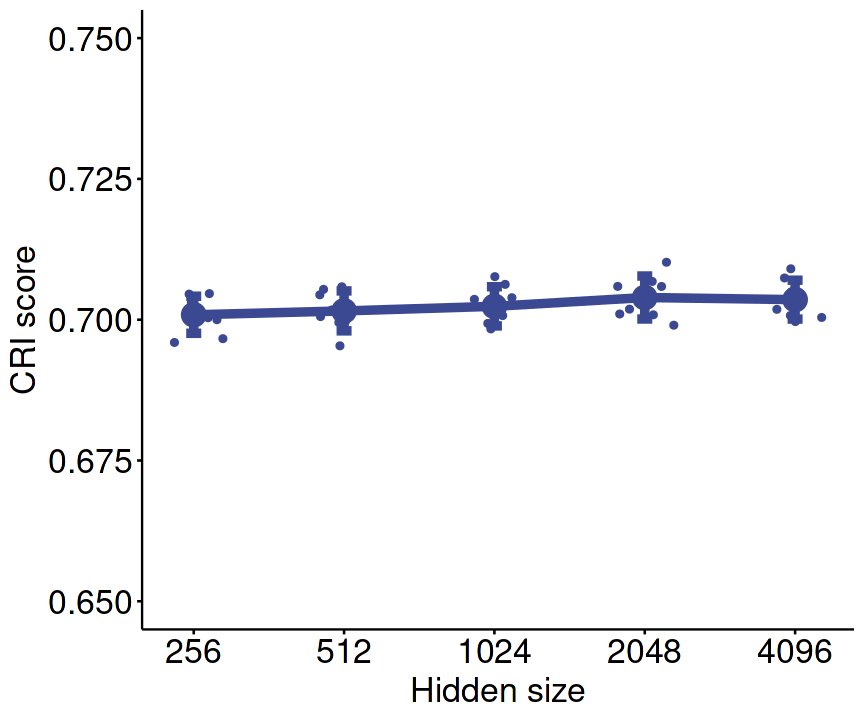

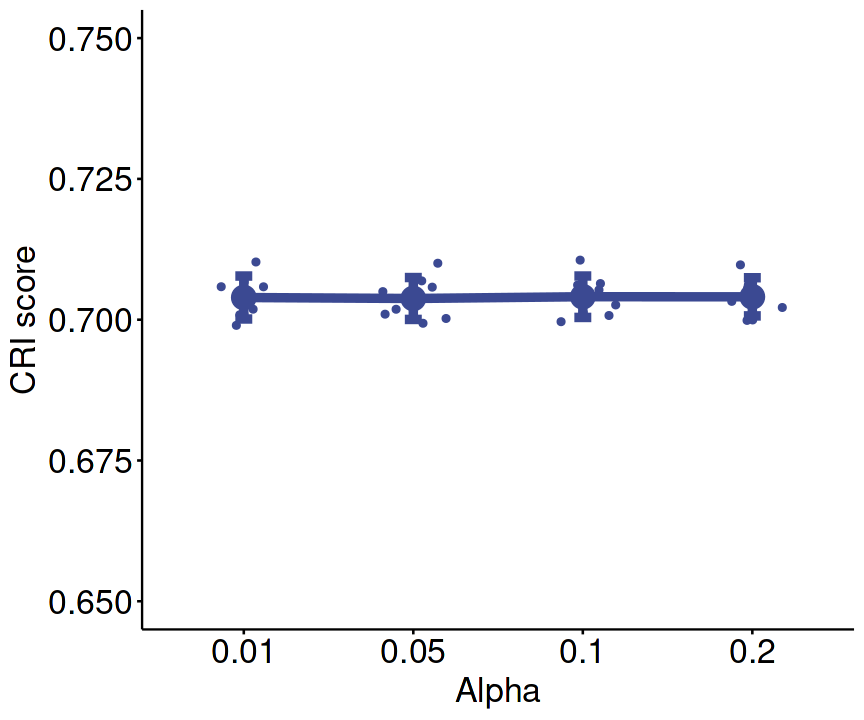

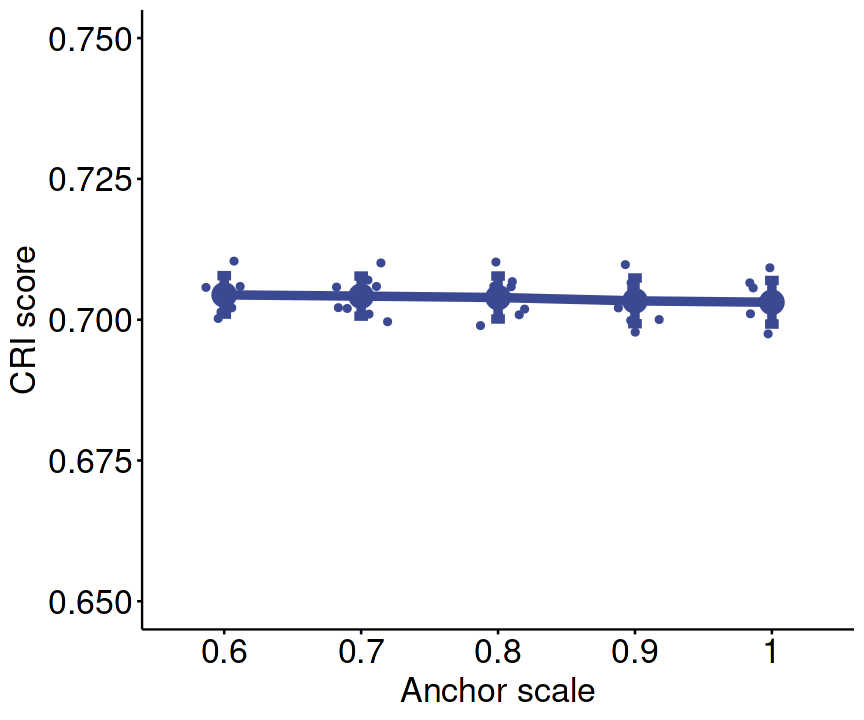

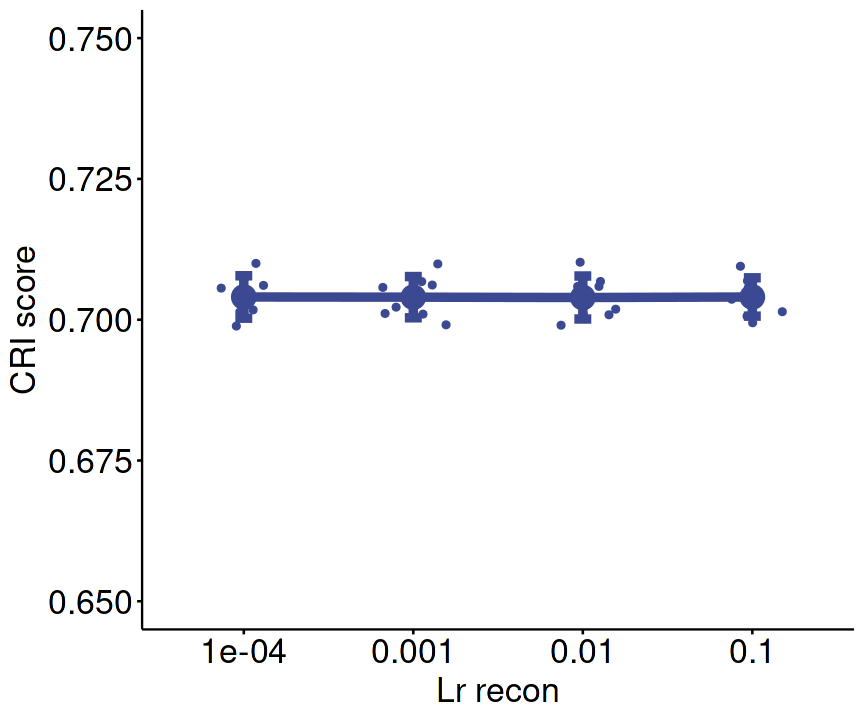

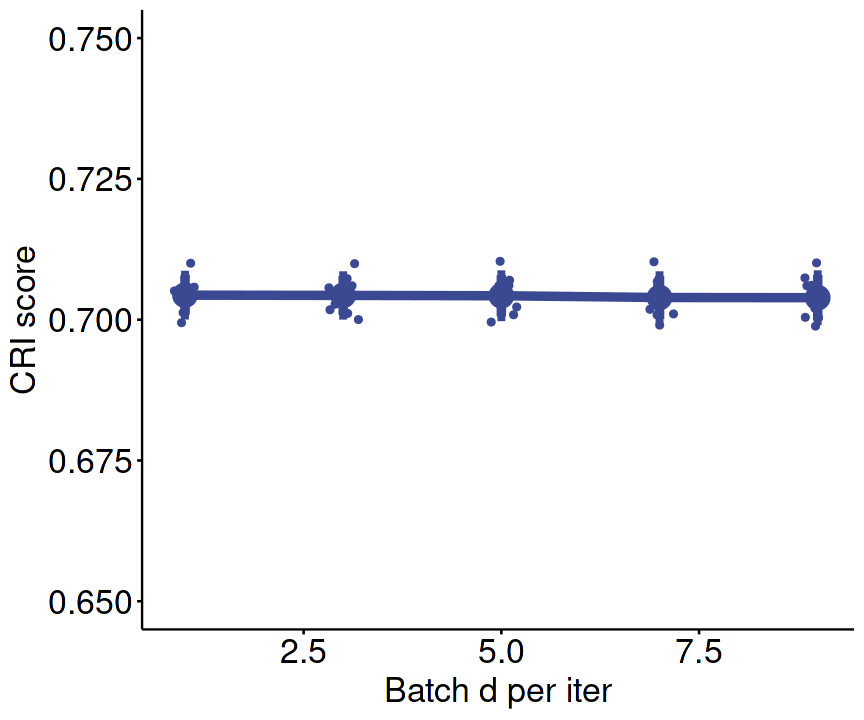

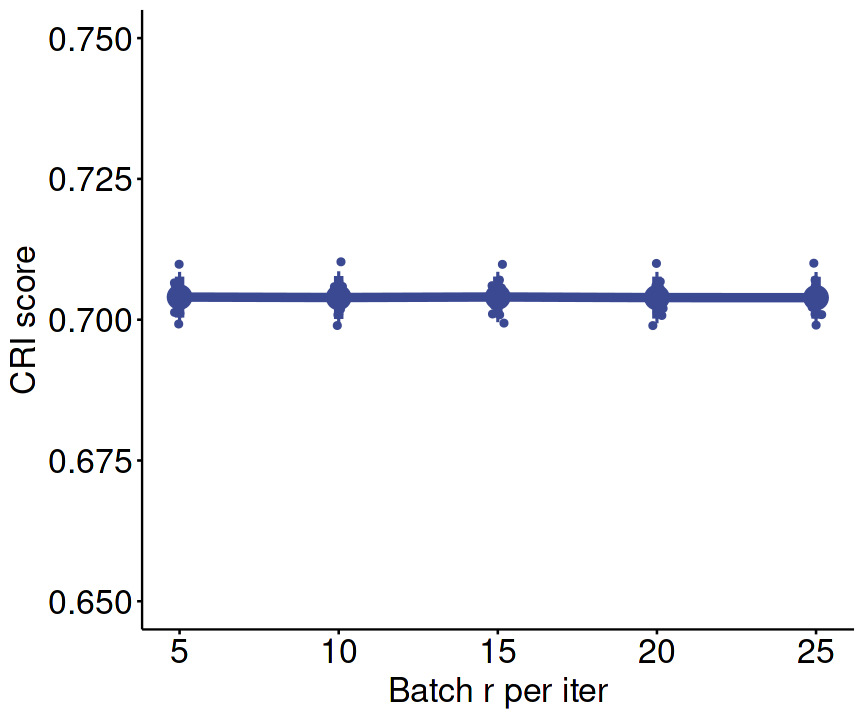

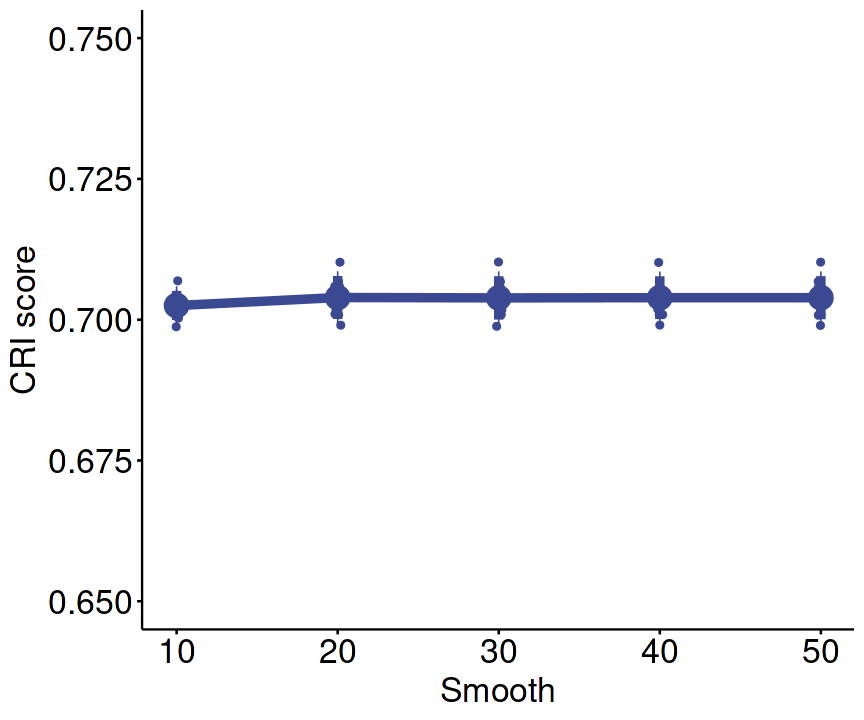

In [5]:
options(repr.plot.width = 7.2, repr.plot.height = 6)
for (param in names(default_param)) {
    # param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        p <- plot_param(df_filter, score, param)
        print(p)
        }
    }


In [6]:
# For feature type only
df_filter <- df[which(df[[param_filter]] == tmp_default_param[param_filter]), ]


# Euclidien distance

In [9]:
plot_param_euc <- function(df, score, variable) {
    # df <- df[c("dataset", "seed", score, variable, 'feature_type')] %>% melt(variable.name = "Index", value.name = "Score",id.vars = c("dataset", "seed", variable))
    plot <- df %>% ggline(variable, score, add = c("mean_sd", "jitter"), color = "feature_type", palette = c("#3b4992","#3b4992","#3b4992"), point.size = 5, size = 2,
                            xlab = str_replace_all(str_to_title(variable), "_", " "), ylab = "Euclidien distance") %>%
            ggpar(font.x = 20, font.y = 20, font.legend = 20, font.subtitle = 20, font.xtickslab = 20, font.ytickslab = 20, legend = "right", ylim = c(0, 0.075)) + 
            # facet_wrap(~dataset, scales="free") +
            rremove("legend")
            # scale_fill_discrete(labels=c(str_replace(str_to_title(score),"_"," ")))
    # print(variable)
    if (str_detect(variable, 'hidden')) {
        plot <- plot + scale_x_continuous(trans='log2')
    } else if (str_detect(variable, 'batch_d_per_iter')) {
       plot <- plot + scale_x_continuous(breaks = c(1,3,5,7,9))
    }
    return(plot)
}

`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


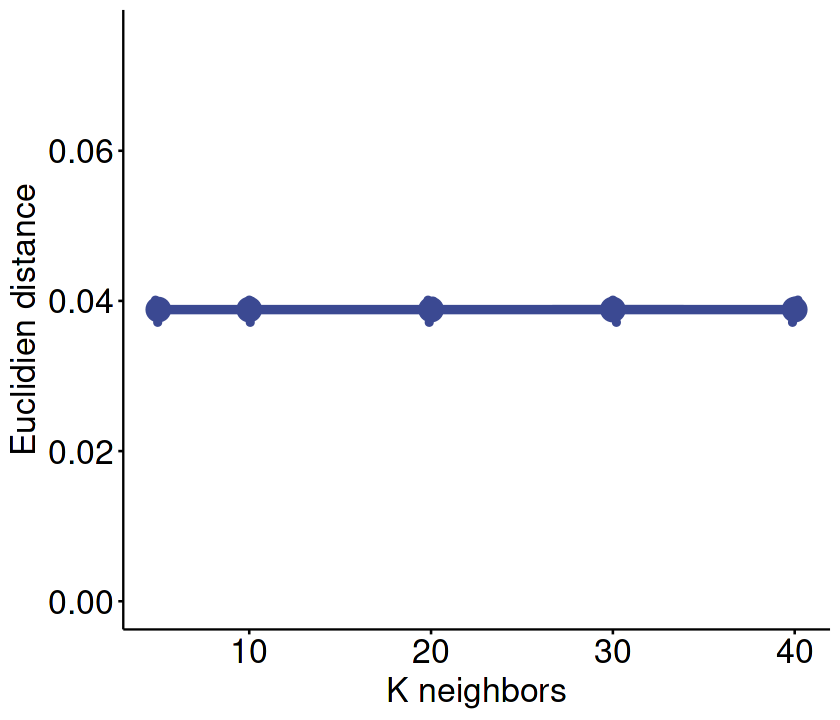

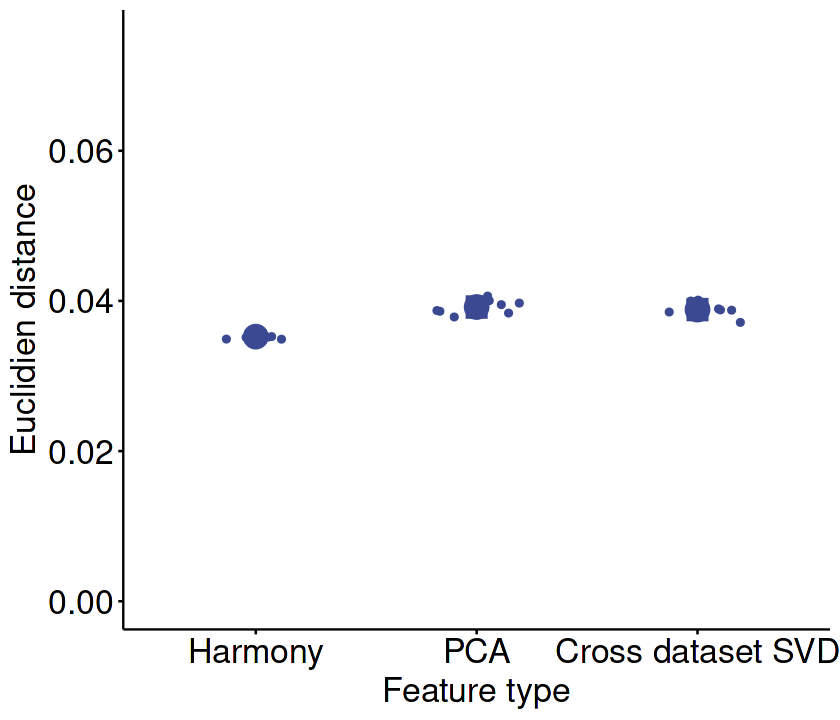

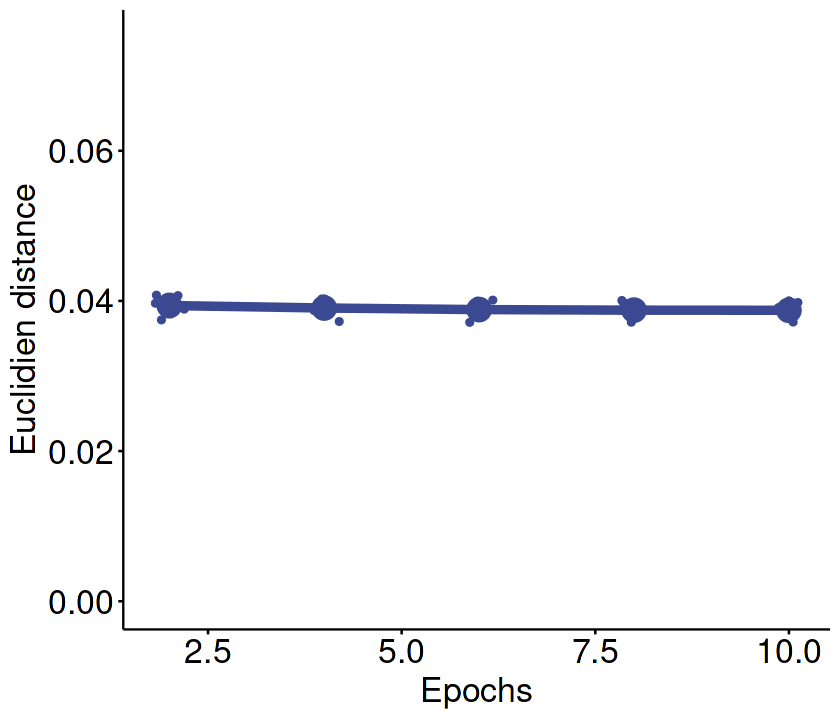

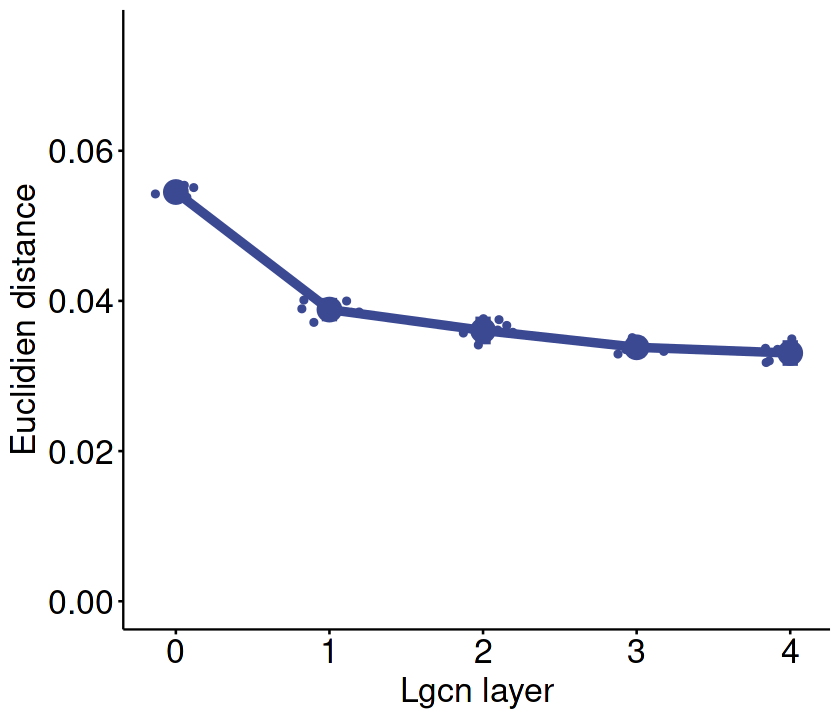

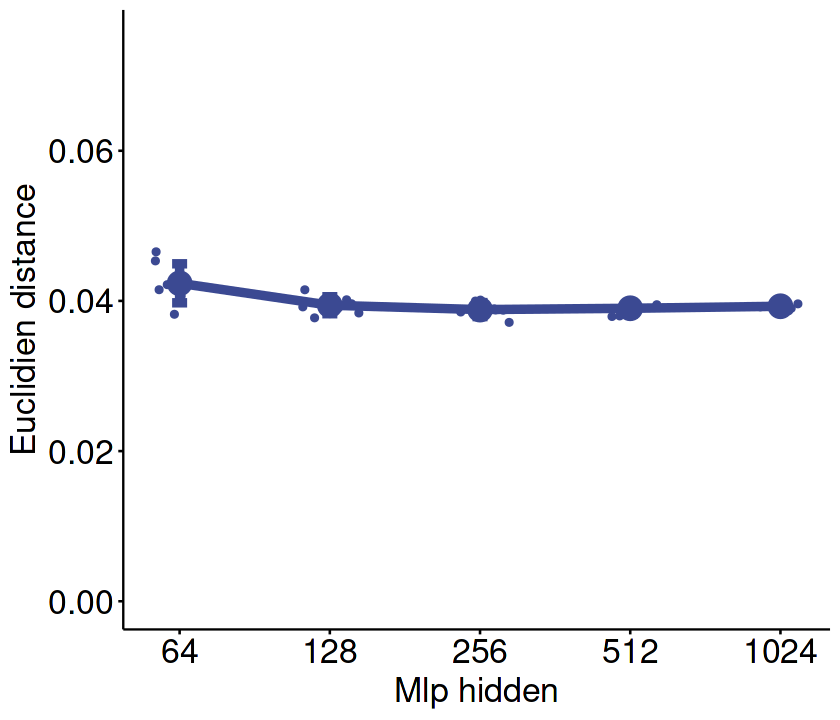

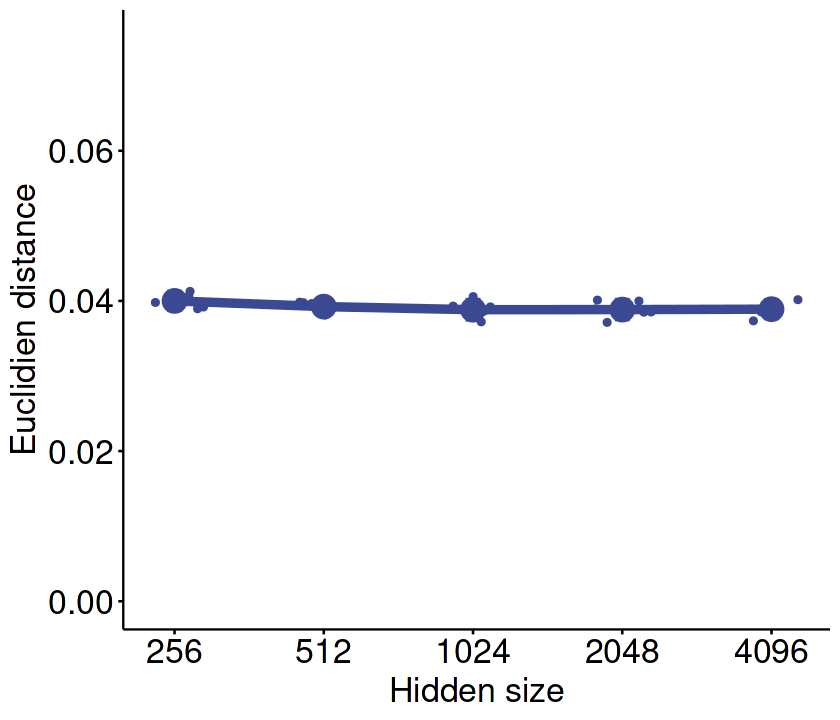

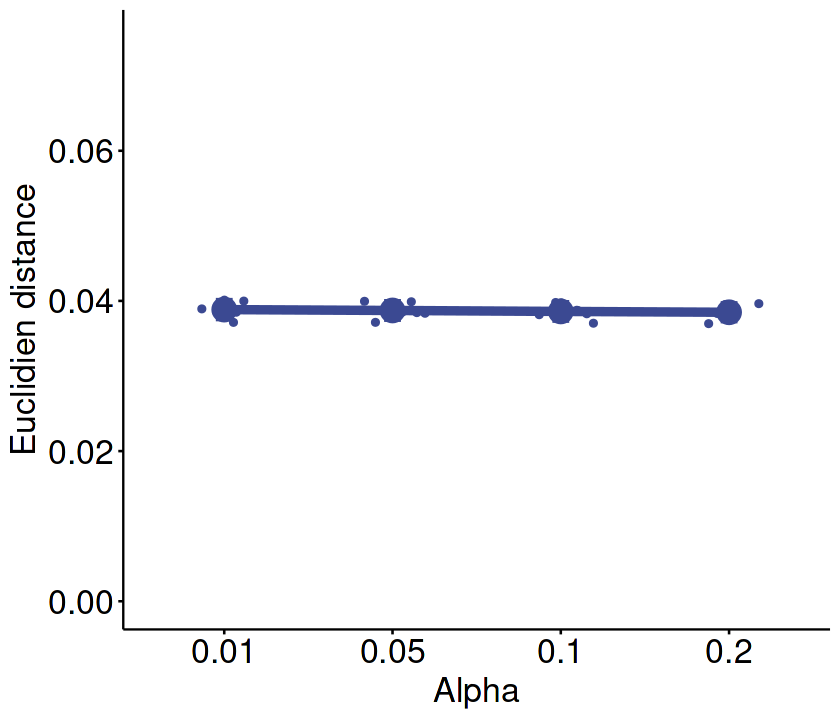

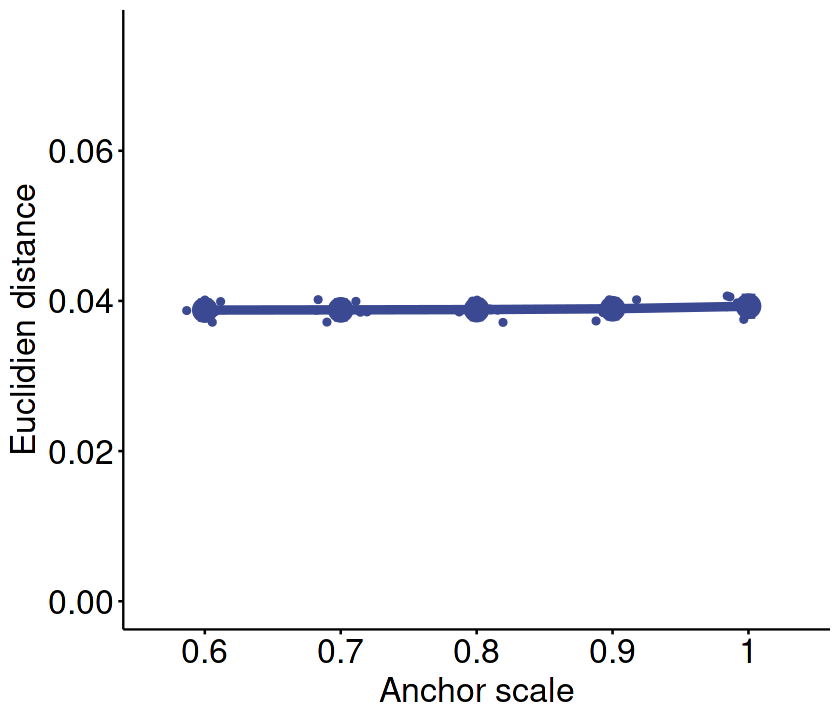

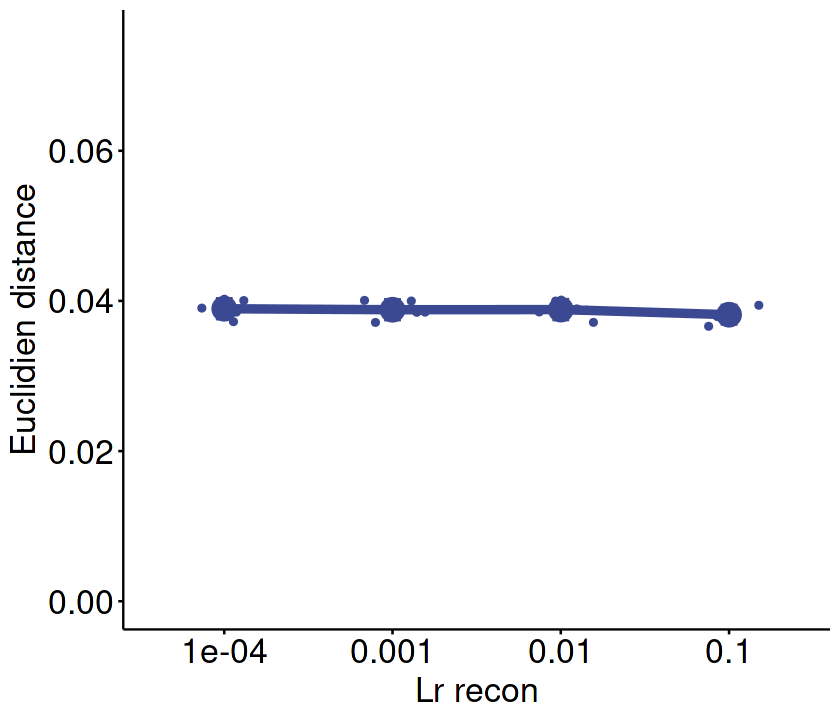

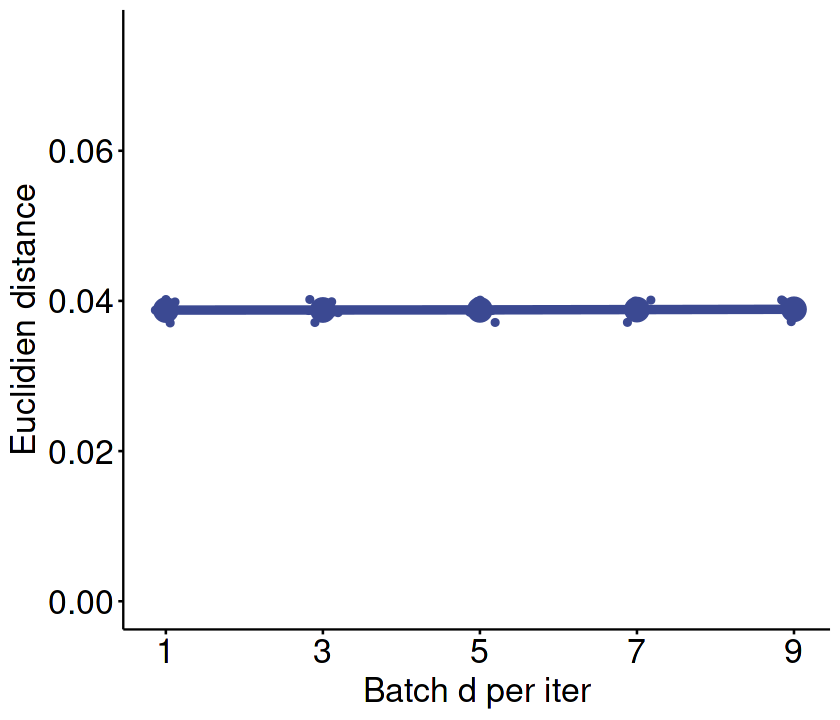

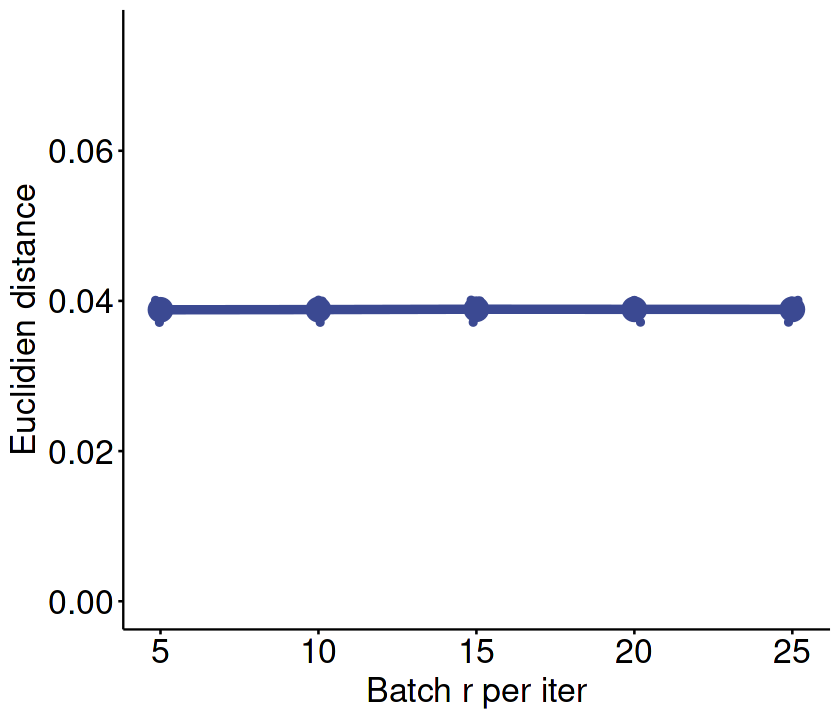

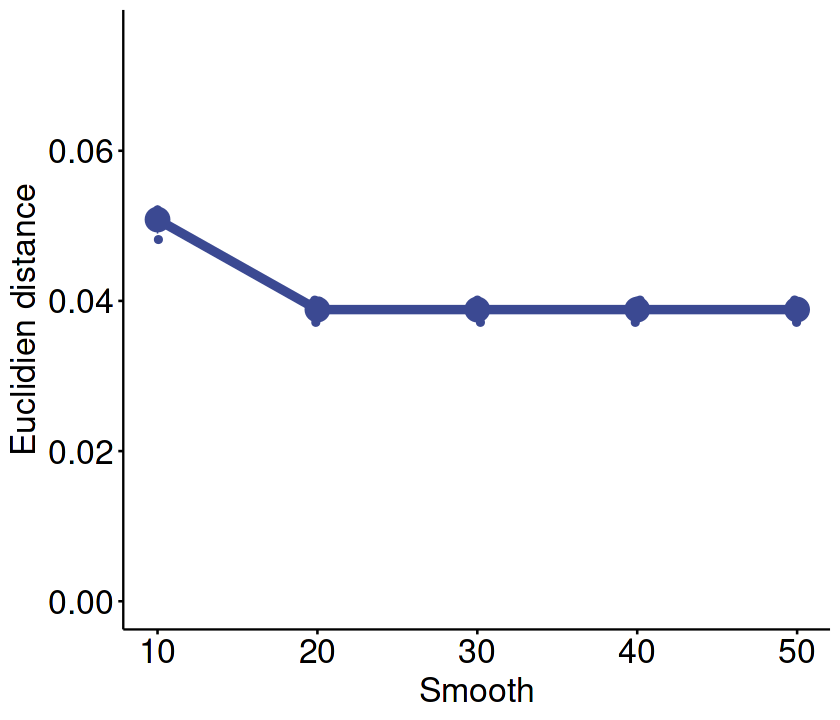

In [10]:
scores <- c("euclidean_dis")
options(repr.plot.width = 7, repr.plot.height = 6)
for (param in names(default_param)) {
    # param %>% print()
    tmp_default_param <- default_param[names(default_param) != param]
    df_filter <- df
    for (param_filter in names(tmp_default_param)) {
        df_filter <- df_filter[which(df_filter[[param_filter]] == tmp_default_param[param_filter]), ]
        }
    if (length(unique(df_filter[[param]])) == 1) {
        next
    }
    for (score in scores) {
        # print(df_filter %>% head(3))
        p <- plot_param_euc(df_filter, score, param)
        print(p)
        }
    }